In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import train_test_split

# load functions defined in MNISTFunctions.py
from MNISTFunctions import digit_plot, multidigits_plot, multi_estimators_results

### Load data and split it into train and test set

In [2]:
digits = pd.read_csv('Data/train.csv')

X = digits.drop('label', axis=1)
y = digits['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set shape :', X_train.shape)
print('Test set shape :', X_test.shape)

Train set shape : (33600, 784)
Test set shape : (8400, 784)


### The distribution of digits in  the dataset.

In [3]:
y_count = y.value_counts()
y_pct = y_count/len(y)*100
y_pct.round(2)

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

It's quite balanced, not a perfect 10% for every digits, but that's fine.

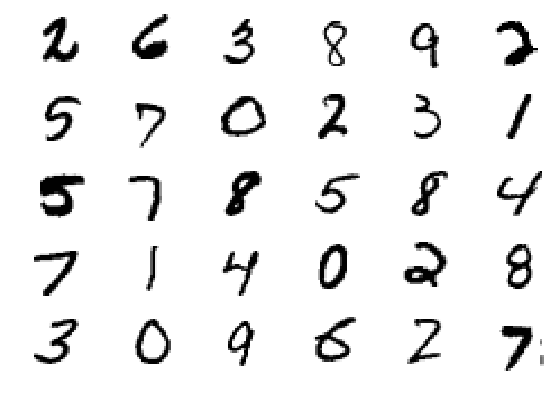

In [4]:
digits = X.sample(30)
multidigits_plot(digits)

# Principal Components Analysis

PCA compute the eigen vectors which explains the largest amount of variance of the data in his original base of vectors (the original features). It can be used to reduce considerably the dimenionnality while preserving most of the information of the data in his original form.

In [5]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

# Get X_train in the base of pca
X_train_pca = pca.transform(X_train)

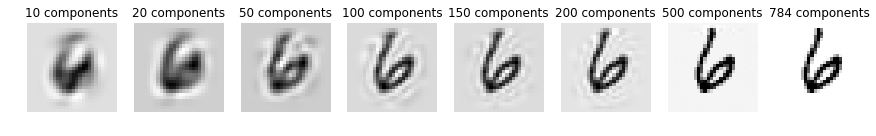

In [6]:
# Do the inverse transform after having selected only the first i rows

n_first_components = [10, 20, 50, 100, 150, 200, 500, 784]

n_len = len(n_first_components)
fig, ax = plt.subplots(1,n_len)

for i, ax in zip(n_first_components, ax):
    # select a copy of a digit from X_train_pca
    digit_pca = X_train_pca[0].copy()
    digit_pca[i:] = 0
    digit_reformed = pca.inverse_transform(digit_pca)
    #plot the digit
    digit_plot(digit_reformed, ax=ax)
    ax.set_title(str(i)+' components')
    
fig.set_size_inches(15,5)

We see that PCA is very effective at reducing the number of features while still retaining enough information to be able to recognize the value of the digit.

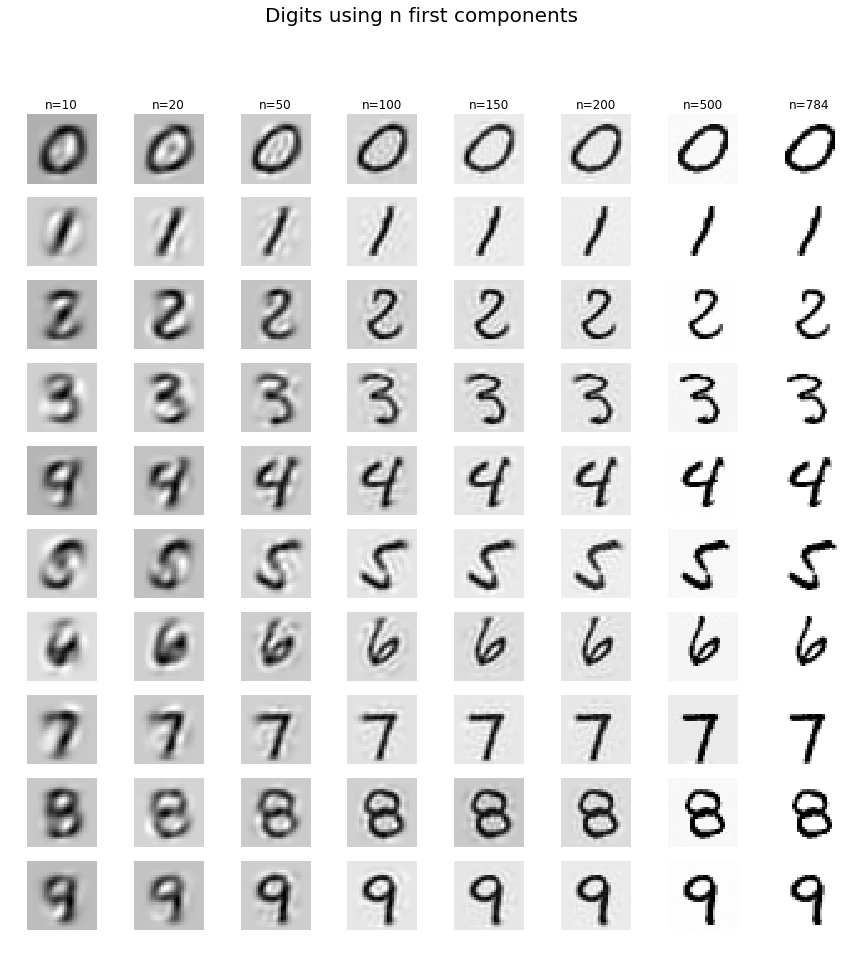

In [7]:
digits = []
for i in range(10):
    i_digits = X_train_pca[y_train==i, :]
    i_digit = i_digits[0]
    digits.append(i_digit)
    
n_first_components = [10, 20, 50, 100, 150, 200, 500, 784]

n_digits = len(digits)
n_len = len(n_first_components)
fig, ax = plt.subplots(n_digits, n_len)

first_row = True
for digit, ax in zip(digits, ax):
    for i, ax in zip(n_first_components, ax):
        # select a copy of a digit from X_train_pca
        digit_pca = digit.copy()
        digit_pca[i:] = 0
        digit_reformed = pca.inverse_transform(digit_pca)
        #plot the digit
        digit_plot(digit_reformed, ax=ax)
        
        # write number of components if first row
        if first_row:
            ax.set_title('n='+str(i))
            
    first_row = False
            
plt.suptitle('Digits using n first components', fontsize=20)
fig.set_size_inches(15,15)

We see that a sweetspot for the number of compents to use is around 50-100, anything above 100 doesn't bring more useful information. We can also choose the number of components to keep by imposing a minimum threshold of variance to keep, 95 % for example.

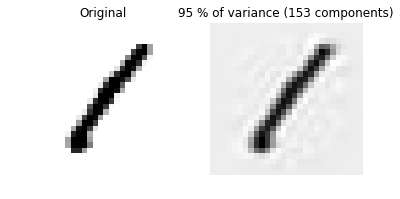

In [8]:
pca_95 = PCA(0.95, svd_solver='full')
pca_95.fit(X_train)

# Get X_train in the base of pca
digit = X_train.loc[0,:]

digit_pca_95 = pca_95.transform(digit.values.reshape(1,-1))
digit_95 = pca_95.inverse_transform(digit_pca_95)

n_components = len(pca_95.components_)

fig, ax = plt.subplots(1,2)
digit_plot(digit, ax=ax[0])
ax[0].set_title('Original')

digit_plot(digit_95, ax=ax[1])
ax[1].set_title('95 % of variance ({} components)'.format(n_components));

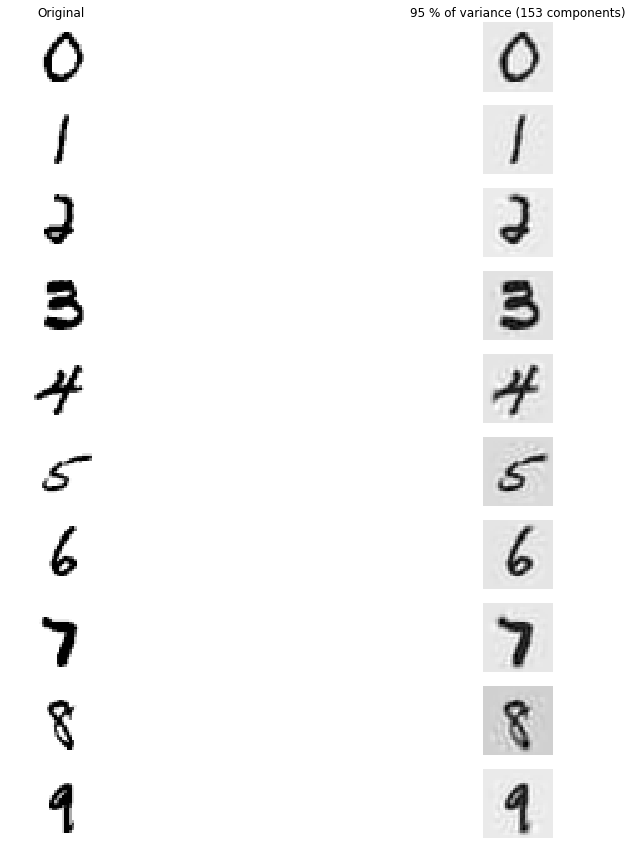

In [9]:
digits = []
for i in range(10):
    i_digits = X_train.loc[y_train==i, :]
    i_digit = i_digits.sample(1)
    digits.append(i_digit.values)

n_digits = len(digits)

fig, ax = plt.subplots(n_digits, 2)

first_row = True
for digit, ax in zip(digits, ax):
    digit_pca_95 = pca_95.transform(digit.reshape(1,-1))
    digit_95 = pca_95.inverse_transform(digit_pca_95)
    
    digit_plot(digit, ax=ax[0])

    digit_plot(digit_95, ax=ax[1])
    
    if first_row:
        ax[0].set_title('Original')
        ax[1].set_title('95 % of variance ({} components)'.format(n_components))
            
    first_row = False
            
#plt.suptitle('Digits using n first components', fontsize=20)
fig.set_size_inches(15,15)

Let'see now what the first components looks like when reshaped into an image.

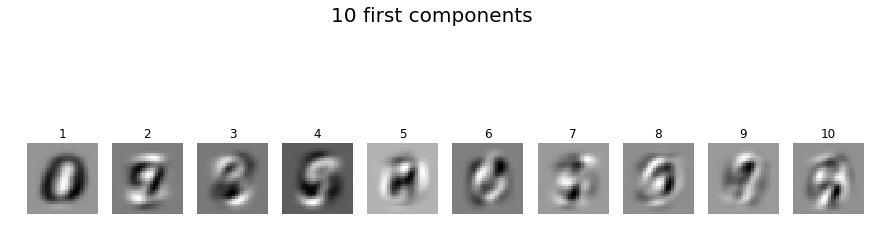

In [10]:
components = pca.components_

n_first_components = list(range(10))

n_len = len(n_first_components)
fig, ax = plt.subplots(1,n_len)

for i, ax in zip(n_first_components, ax):
    component = components[i]

    #plot the component
    digit_plot(component, ax=ax)
    ax.set_title(str(i+1))
plt.suptitle('10 first components', fontsize=20)
fig.set_size_inches(15,5)

## 2D representation

Let's plot in 2 dimension the differents digits, using the two first components.

In [11]:
pca_2 = PCA(2)
pca_2.fit(X_train)

# select 100 random digits and project them on the 2 first principal components
digits_idx = X_train.sample(500).index
X_2 = pca_2.transform(X_train.loc[digits_idx, :])
targets = y_train.loc[digits_idx]

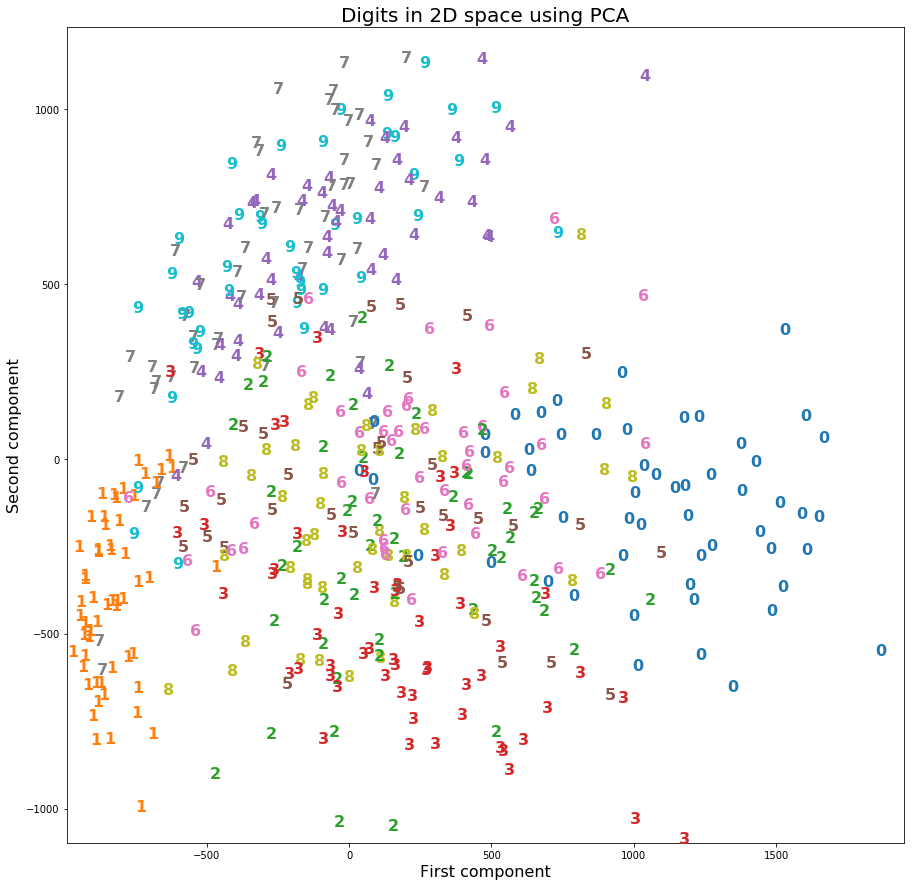

In [12]:
plt.figure(figsize=(15,15))
plt.xlim(X_2[:,0].min(), X_2[:,0].max()+100)
plt.ylim(X_2[:,1].min(), X_2[:,1].max()+100)

colors = {0:'C0', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7', 8:'C8', 9:'C9'}

for x, y, target in zip(X_2[:,0], X_2[:,1], targets.values):
    plt.text(x, y, str(target), color=colors[target], fontdict={'weight':'bold', "size":16})

plt.xlabel('First component', fontsize=16)
plt.ylabel('Second component', fontsize=16)
plt.title('Digits in 2D space using PCA', fontsize=20);

This representation in 2D space let us see which digits are the most similar, and so, the most prone to confusion (when using only the two first components). We see that the **2**, **3**, **6** and **8** are overlapping a lot, while the **1** and **0** are the most distinct. The **7**, **9** and **4** are also overlapping a lot.

## t-SNE

Another method to represent our data in a 2D space is t-SNE, a manifold learning method. It finds a new 2D space for the data where similar points are grouped togheter. 

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)

digits_tsne = tsne.fit_transform(X_train.loc[digits_idx,:])

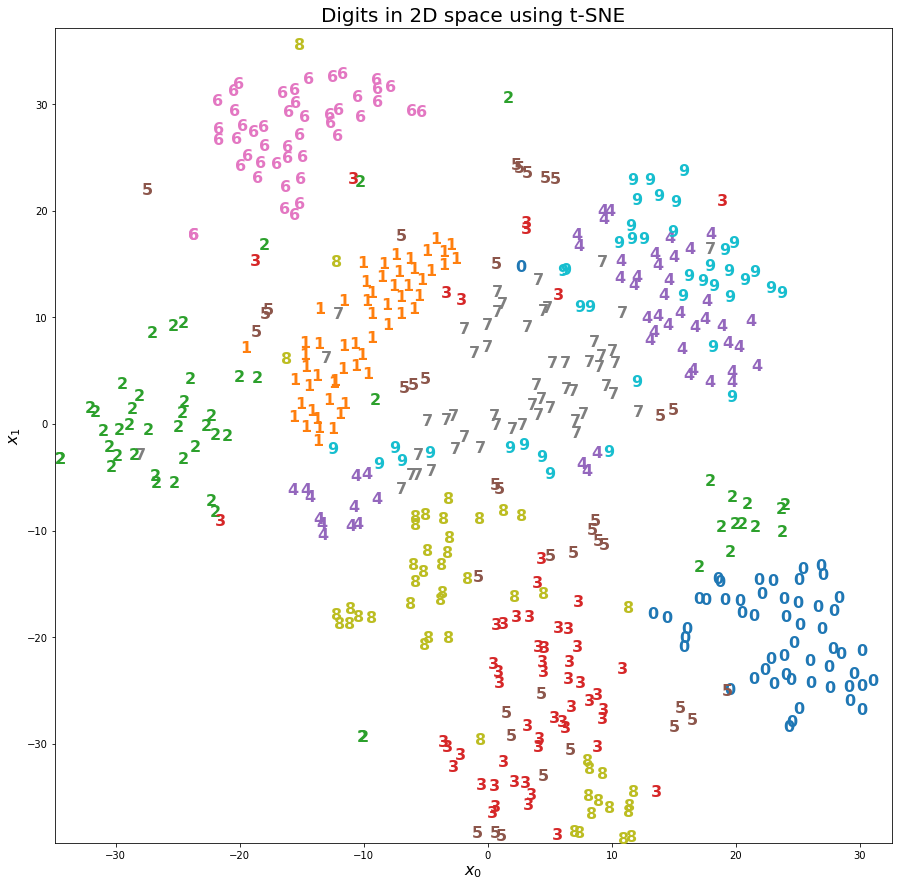

In [14]:
plt.figure(figsize=(15,15))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+2)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+2)

colors = {0:'C0', 1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7', 8:'C8', 9:'C9'}

for x, y, target in zip(digits_tsne[:,0], digits_tsne[:,1], targets.values):
    plt.text(x, y, str(target), color=colors[target], fontdict={'weight':'bold', "size":16})

plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
plt.title('Digits in 2D space using t-SNE', fontsize=20);